# A selection signature across datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyrepseq as prs
import pyrepseq.plotting as pp

from lib import *

plt.style.use('tcrspace.mplstyle')

pcDelta_kwargs = dict(pseudocount=0.0, normalize=True)

## Data loading and preprocessing

In [2]:
back_norms, bins = prs.load_pcDelta_background()

### Dash 2017

In [3]:
dash = pd.read_csv(data_directory+'dash_human.csv')
dash_epitopes = dash['epitope'].unique()
chains = ['alpha', 'beta']
cdr3_columns = {'alpha': 'cdr3_a_aa',
                'beta' : 'cdr3_b_aa'}
dash_pcDeltas_dict = {}
for chain in chains:
    dash_pcDeltas_dict[chain] = prs.pcDelta_grouped(dash, 'epitope',
                                                    cdr3_columns[chain],
                                                    **pcDelta_kwargs)
dash_pcDeltas_dict['both'] = prs.pcDelta_grouped(dash, 'epitope',
                                                [cdr3_columns[chain] for chain in chains],
                                                **pcDelta_kwargs)

### Nolan 2020

In [4]:
mira = pd.read_csv(data_directory + 'mira/processed/peptide-detail-ci.csv')
mira['nAminoAcids'] = mira['Amino Acids'].apply(lambda s: len(s.split(',')))
mask = mira['nAminoAcids']==1
mask &= mira['amino_acid'].apply(prs.isvalidcdr3)
mira = mira[mask]
mira = mira.groupby('Amino Acids').filter(lambda x: len(x) > 150)

In [5]:
mira_pcDeltas = prs.pcDelta_grouped(mira, 'Amino Acids', 'amino_acid', **pcDelta_kwargs)

### Minervina 2021

In [6]:
minervina_hist_norms = {}
# contracting from day 15 to 85
chain_to_table = {'alpha' : 4,
                  'beta': 3}
for chain in ['alpha', 'beta']:
    minervina = pd.read_csv(f'{data_directory}minervina/Table_S{chain_to_table[chain]}.tsv', sep='\t')
    for cd in [4, 8]:
        for donor in ['M', 'W', 'both']:
            if donor == 'both':
                distances = []
                for d in ['M', 'W']:
                    seqs = minervina[(minervina['CD']==f'CD{cd}')]['CDR3.amino.acid.sequence']
                    distances.append(prs.pdist(seqs))
                np.concatenate(distances)
            else:
                seqs = minervina[(minervina['CD']==f'CD{cd}')
                                &(minervina['donor']==donor)]['CDR3.amino.acid.sequence']
                distances = prs.pdist(seqs)

            print(chain, cd, donor, len(seqs))
            hist, bins_ = np.histogram(distances, bins=bins)
            minervina_hist_norm = hist/np.sum(hist)
            minervina_hist_norms[chain, cd, donor] = minervina_hist_norm

alpha 4 M 306
alpha 4 W 204
alpha 4 both 510
alpha 8 M 300
alpha 8 W 83
alpha 8 both 383
beta 4 M 325
beta 4 W 218
beta 4 both 543
beta 8 M 287
beta 8 W 70
beta 8 both 357


### Tanno 2020

In [7]:
dfs = {filename : pd.read_csv(f'{data_directory}tanno/pruned/pdist_{filename}.csv')
       for filename in tannofiles}

In [8]:
def N_from_pairs(pairs):
    return round((1+np.sqrt(1+8*pairs))/2)

In [9]:
fabs = []
for filename, df in dfs.items():    
    if 'naive' in filename or 'memory' in filename:
        continue
    cab = df['count_pair']
    if N_from_pairs(np.sum(cab)) < 25000:
        continue
        
    fab = df['freq_pair']
    fabs.append(fab)

fab = np.array(fabs).mean(axis=0)

### Minervina 2022

In [10]:
df = pd.read_csv(f'{data_directory}/minervina2022.csv')
df = df.groupby('epitope').filter(lambda x: len(x) > 150)
minervina22_pcDeltas = prs.pcDelta_grouped(df, 'epitope', ['cdr3a', 'cdr3b'], **pcDelta_kwargs)

## Putting it all togeter

In [11]:
def func(Delta, A, Deltac, pcb):
    B = 1.0 - np.sum(A*np.exp(-Delta/Deltac)*pcb)
    print(B, A)
    return A*np.exp(-Delta/Deltac) + B

0.827241234264301 491677146.2559957
0.9930056362857353 19906189.86111158
0.9999980092480584 5665.745696926808
0.8526354317166165 4994.726385751065
0.9994580838135556 18.36752963639483
0.6908118173399532 25962.36122062529
0.9911667904559083 741.7197350434778
0.9975086781034891 209.19492600784525


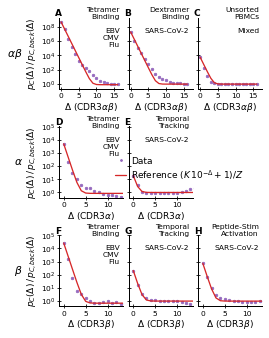

In [12]:
fig, axes_arr = plt.subplots(figsize=(3.54, 4.5),
                         ncols=3, nrows=3,
                         sharex=False, sharey=False)


title_kwargs = dict(ha='right', va='top', size='small')

data_color = 'C4'
fit_color = 'C3'

# xy coordinates for the title annotation of each subplot
title_y = 1.15
title_x = 0.95


Deltac = 1/np.log(10)

#### alpha beta ####

xmax = 17

axes = axes_arr[0, :]
hist_back_norm = back_norms['both']


hist_norm = np.mean(dash_pcDeltas_dict['both'], axis=0)
axes[0].plot(bins[:xmax], hist_norm[:xmax]/hist_back_norm[:xmax], 'o', color=data_color)
A = (hist_norm[:xmax]/hist_back_norm[:xmax])[0]
axes[0].plot(bins[:xmax], func(bins[:xmax], A, Deltac, hist_back_norm[:xmax]),
             color=fit_color)
axes[0].text(title_x, title_y,
             'Tetramer\nBinding\n\nEBV\nCMV\nFlu',
             transform=axes[0].transAxes, **title_kwargs)


hist_norm = minervina22_pcDeltas.mean(axis=0)
axes[1].plot(bins[:xmax], hist_norm[:xmax]/hist_back_norm[:xmax], 'o', color=data_color)
A = (hist_norm[:xmax]/hist_back_norm[:xmax])[0]
axes[1].plot(bins[:xmax], func(bins[:xmax], A, Deltac, hist_back_norm[:xmax]),
             color=fit_color)
axes[1].text(title_x, title_y,
             'Dextramer\nBinding\n\nSARS-CoV-2',
             transform=axes[1].transAxes, **title_kwargs)

hist_norm = fab
axes[2].plot(bins[:xmax], hist_norm[:xmax]/hist_back_norm[:xmax],
             'o', color=data_color)
A = hist_norm[0]/hist_back_norm[0]
axes[2].plot(bins[:xmax], func(bins[:xmax], A, Deltac,
             hist_back_norm[:xmax]), color=fit_color)
axes[2].text(title_x, title_y,
             'Unsorted\nPBMCs\n\nMixed',
             transform=axes[2].transAxes, **title_kwargs)


axes[0].set_ylabel(r'$p_C(\Delta)\,/\,p_{C,back}(\Delta)$')
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(-0.5, 17.5)
    ax.set_ylim(2e-1, 2e9)
    ax.set_yticks(10**np.arange(0, 10, 2))
    ax.set_xticks(np.arange(0, 20, 5))
    ax.set_xlabel(r'$\Delta$ (CDR3$\alpha\beta$)')
for ax in axes[1:]:
    ax.set_yticklabels([])

#### alpha ####

axes = axes_arr[1, :]

hist_norm = np.mean(dash_pcDeltas_dict['alpha'], axis=0)
hist_back_norm = back_norms['alpha'][:len(hist_norm)]
axes[0].plot(bins[:-1], hist_norm / hist_back_norm, 'o', label='Data', color=data_color)
A = (hist_norm / hist_back_norm)[0]
axes[0].plot(bins[:-1], func(bins[:-1], A, Deltac, hist_back_norm),
             label=r'$\frac{K \, 10^{-\Delta}+1}{Z}$', color=fit_color)
axes[0].text(title_x, title_y,
             'Tetramer\nBinding\n\nEBV\nCMV\nFlu',
             transform=axes[0].transAxes, **title_kwargs)

chain = 'alpha'
cd = 8
donor = 'both'
hist_norm = minervina_hist_norms[chain, cd, donor]
axes[1].plot(bins[:-1], hist_norm / hist_back_norm, 'o', color=data_color)
A = (hist_norm / hist_back_norm)[0]
axes[1].plot(bins[:-1], func(bins[:-1], A, Deltac, hist_back_norm), color=fit_color)
axes[1].text(title_x, title_y,
             'Temporal\nTracking\n\nSARS-CoV-2',
             transform=axes[1].transAxes,  **title_kwargs)

axes[0].set_ylabel(r'$p_C(\Delta)\,/\,p_{C,back}(\Delta)$')
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel(r'$\Delta$ (CDR3$\alpha$)')
    ax.set_xlim(-1, 13.5)
    ax.set_ylim(4e-1, 1.1e5)
    ax.set_xticks(np.arange(0, 14, 5))
    ax.set_yticks(10**np.arange(6))
for ax in axes[1:]:
    ax.set_yticklabels([])
axes_arr[1, 2].remove()


#### beta ####

axes = axes_arr[2, :]

hist_norm = np.mean(dash_pcDeltas_dict['beta'], axis=0)
hist_back_norm = back_norms['beta'][:len(hist_norm)]
axes[0].plot(bins[:-1], hist_norm / hist_back_norm, 'o', label='Data', color=data_color)
A = (hist_norm / hist_back_norm)[0]
axes[0].plot(bins[:-1], func(bins[:-1], A, Deltac, hist_back_norm),
             label=r'Reference $(K \, 10^{-\Delta}+1)/Z$', color=fit_color)
axes[0].text(title_x, title_y,
             'Tetramer\nBinding\n\nEBV\nCMV\nFlu',
             transform=axes[0].transAxes, **title_kwargs)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(0.95, 0.5))

hist_norm = np.mean(mira_pcDeltas, axis=0)
axes[2].plot(bins[:-1], hist_norm / hist_back_norm, 'o', color=data_color)
A = (hist_norm / hist_back_norm)[0]
axes[2].plot(bins[:-1], func(bins[:-1], A, Deltac, hist_back_norm), color=fit_color)
axes[2].text(title_x, title_y,
             'Peptide-Stim\nActivation\n\nSARS-CoV-2',
             transform=axes[2].transAxes,  **title_kwargs)

chain = 'beta'
cd = 8
donor = 'both'
hist_norm = minervina_hist_norms[chain, cd, donor]
axes[1].plot(bins[:-1], hist_norm / hist_back_norm, 'o', color=data_color)
A = (hist_norm / hist_back_norm)[0]
axes[1].plot(bins[:-1], func(bins[:-1], A, Deltac, hist_back_norm), color=fit_color)
axes[1].text(title_x, title_y,
             'Temporal\nTracking\n\nSARS-CoV-2',
             transform=axes[1].transAxes,  **title_kwargs)

axes[0].set_ylabel(r'$p_C(\Delta)\,/\,p_{C,back}(\Delta)$')
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel(r'$\Delta$ (CDR3$\beta$)')
    ax.set_xlim(-1, 13.5)
    ax.set_ylim(4e-1, 1.1e5)
    ax.set_xticks(np.arange(0, 14, 5))
    ax.set_yticks(10**np.arange(6))
for ax in axes[1:]:
    ax.set_yticklabels([])

pad = 1.0
for ax, row in zip(axes_arr[:,0], [r'$\alpha\beta$', r'$\alpha$', r'$\beta$',]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')


pp.label_axes(fig, xy=(-0.07, 1.12))
fig.tight_layout(h_pad=0.2, w_pad=0.2, pad=0.0)

fig.savefig('figures/raw/figure3.svg')